In [1]:
from __future__ import unicode_literals

import sys, os
BIN = os.path.expanduser("../../")
sys.path.append(BIN)

import numpy as np
from scipy.constants import m_p, c, e, pi
from scipy import interpolate
import matplotlib.pyplot as plt
%matplotlib inline

import copy
import itertools
import math


from PyHEADTAIL_feedback.processors.signal import SignalParameters
from PyHEADTAIL_feedback.processors.addition import NoiseGenerator
from PyHEADTAIL_feedback.processors.convolution import Lowpass, PhaseLinearizedLowpass, Sinc
# Filters based on linear transform could bealso used, but they are at least an order of magnitude slower in this contex
# from PyHEADTAIL_feedback.processors.linear_transform import Lowpass, PhaseLinearizedLowpass, Sinc

np.random.seed(0)

In [2]:
class Signal(object):
    def __init__(self, z_bins,z,x,t):
        self.z_bins = z_bins
        self.z = z
        self.x = x
        self.t = t
        self.signal = np.array(x)
        self.bin_edges = np.transpose(np.array([self.z_bins[:-1], self.z_bins[1:]]))
        
    def mean_x(self):
        return self.x
        
    def mean_z(self):
        return self.z

def impulse(f, n_points = 100, amplitude = 1.):
    t_bins = np.linspace(-1./f, 1./f, n_points + 1)

    t = np.array([(i + j) / 2. for i, j in zip(t_bins, t_bins[1:])])

    z_bins = c * t_bins
    z = c * t

    x = np.zeros(len(t))
    for i, val in enumerate(t):
        if val >= 0.:
            x[i] = amplitude
            break
    print np.amax(x)
            
    return Signal(z_bins, z, x, t)
    
def generate_signal(signal_generator, f, amplitude, n_periods, n_per_period, n_zero_periods):
    
    t_min = -1.*n_zero_periods[0]
    t_max = n_periods+n_zero_periods[1]
    t_bins = np.linspace(t_min,t_max,int((t_max-t_min)*n_per_period)+1)
    t = np.array([(i + j) / 2. for i, j in zip(t_bins, t_bins[1:])])

    x = np.zeros(len(t))
    signal_points = (t > 0.) * (t < n_periods)
    x[signal_points] = amplitude * signal_generator(t[signal_points])

    z_bins = c * t_bins / f
    z = c * t / f

    return Signal(z_bins, z, x, t / f )
    
    
def square_impulse(f,amplitude):
    def signal_generator(x):
        signal = np.zeros(len(x))
        for i, val in enumerate(x):

            if 0.< val % 1. < 0.5:
                signal[i] = 1.

            elif 0.5 < val % 1. < 1.0:
                signal[i] = -1.
        return signal

    return generate_signal(signal_generator, f, amplitude, 1, 100, (1,1))
    

def sine_impulse(f,amplitude):
    def signal_generator(x):
        return np.sin(2*pi*x)

    return generate_signal(signal_generator, f, amplitude, 1, 100, (1,1))

def sine_wave(f, amplitude = 1., n_periods=10., n_per_period = 100):
    def signal_generator(x):
        return np.sin(2*pi*x)
    n_zero_periods = (0, 0)
    return generate_signal(signal_generator, f, amplitude, n_periods, n_per_period, n_zero_periods)

def compare_signals(signals,labels,normalized = False, xlabel = None, ylabel = None, title = None):
    fig = plt.figure(figsize=(12, 7))
    ax1 = fig.add_subplot(111)
    
    ax2 = ax1.twiny()
    
    norm_coeff = 1.
    
    for i, (signal,label) in enumerate(zip(signals,labels)):
        if normalized and i == 0:
            norm_coeff = np.amax(signal.signal)

        ax1.plot(signal.t, signal.signal/norm_coeff,label=label)
        ax2.plot(signal.z, np.ones(len(signal.z))) # Create a dummy plot
        ax2.cla()

    
    if xlabel is not None:
        ax1.set_xlabel(xlabel)
    else:
        ax1.set_xlabel('Time [s]')
    
    if ylabel is not None:
        ax1.set_ylabel(ylabel)
    elif normalized:
        ax1.set_ylabel('Normalized amplitude')
    else:
        ax1.set_ylabel('Amplitude')
        
    ax1.legend(loc='upper right')
    
    ax2.set_xlabel('Distance [m]')
    if title is not None:
        title = ax1.set_title(title)
        title.set_y(1.1)
    
    plt.show()
    
def process_signal(signal,processors):
    signal_parameters = SignalParameters(0,signal.bin_edges,1,len(signal.bin_edges),[0.],0.)
    for processor in processors:
        signal_parameters, signal.signal = processor.process(signal_parameters, signal.signal,slice_sets = [signal])

In [3]:
def frequency_response(processors, time_scale, resp_symmetry='symmetric', f_range = None, 
                       n_f_points = 31, n_min_periods = 15, n_min_per_period = 48):

    def calculate_parameters(t_period,t,signal,ref_signal):
        phase_steps = np.linspace(-100,100,2001)
        values = []

        ref_data_points = None

        if resp_symmetry == 'symmetric':
            start_period = np.floor((np.amax(t) - np.amin(t))/(2.*t_period))
            ref_data_points = (t >= ((start_period - 1.)* t_period))*(t < ((start_period + 1.)* t_period))
        elif resp_symmetry == 'delayed':
            ref_data_points = (t >= (np.amax(t) - 3.* t_period))*(t < (np.amax(t) - 1.* t_period))
        elif resp_symmetry == 'advanced':
            ref_data_points = (t >= (np.amin(t) + 1.* t_period))*(t < (np.amin(t) + 3.* t_period))

        ref_data_time = t[ref_data_points]
        ref_data = ref_signal[ref_data_points]
        amplitude_data = signal[ref_data_points]
        for phase in phase_steps:
            tck = interpolate.splrep(t + phase * t_period / 360., response, s=0)
            cor_data = interpolate.splev(ref_data_time, tck, der=0)
            values.append(np.sum(ref_data*cor_data))

        values = np.array(values)
        phase_shift_point = values == np.max(values)
        phase_shift = phase_steps[phase_shift_point]
        phase_shift = phase_shift[0]
        amplitude = np.amax(np.abs(amplitude_data))

        return amplitude, phase_shift

    if f_range is None:
        frequencies = np.logspace(np.log10(0.01 / time_scale), np.log10(100. / time_scale), n_f_points)
    else:
        frequencies = np.logspace(np.log10(f_range[0]),np.log10(f_range[1]),n_f_points)

    amplitudes = []
    phase_shifts = []

    for f in frequencies:
        n_periods = max(n_min_periods, int(math.ceil(1.*time_scale*f)))
        n_per_period = max(n_min_per_period,4./(time_scale*f))

        processors_for_use = copy.deepcopy(processors)
        signal = sine_wave(f,1.,n_periods,n_per_period)

        timed = signal.t
        impulse = signal.signal
        process_signal(signal,processors_for_use)
        response = signal.signal

        amplitude, phase_shift = calculate_parameters(1./f,timed,response,impulse)

        amplitudes.append(amplitude)
        phase_shifts.append(phase_shift)

    return frequencies, np.array(amplitudes), np.array(phase_shifts)

In [4]:
""" In this example, the signal modifications in different ("analog") signal processors are 
    demonstrated. In here, only different low pass filters are compared. However, the same scripts can be used for
    visializing any (list of) signal processors. 
    
    In order to clarify the presentation signals are produced independently from PyHEADTAIL
"""

u' In this example, the signal modifications in different ("analog") signal processors are \n    demonstrated. In here, only different low pass filters are compared. However, the same scripts can be used for\n    visializing any (list of) signal processors. \n    \n    In order to clarify the presentation signals are produced independently from PyHEADTAIL\n'

In [5]:
f_s = 1e8 #[Hz] Frequency scale used in this example

In [6]:
# Bandwidth of a feedback system (and lowpass filter) is often defined by using a term cutoff frequency. 
# In many cases high frequency behavior limits the system , which means that signals at 
# frequencies below the cut off frequencies pass through the system while signals at the freuqencies above 
# the cutoff are attenuated.
#
# The simplest model for the bandwidth limitation at high frequencies is a lowpass filter. At the moment there are
# three different lowpass filters implemented to the signal processors: RC-filter, phase linearized lowpass 
# filter and sinc filter. 

# Frequency responses of those filters differ and are presented in the figure below

#######################################################
# This calculation takes some time. Please be patient #
#######################################################
processors_rc = [Lowpass(f_s)]
f_rc, amp_rc, phase_rc = frequency_response(processors_rc, 1./f_s)
processors_pl = [PhaseLinearizedLowpass(f_s)]
f_pl, amp_pl, phase_pl = frequency_response(processors_pl, 1./f_s)
processors_sinc = [Sinc(f_s)]
f_sinc, amp_sinc, phase_sinc = frequency_response(processors_sinc, 1./f_s)


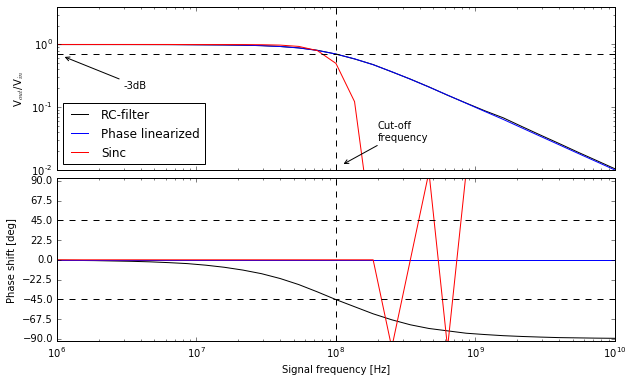

In [7]:
fig = plt.figure(figsize=(10, 6))

ax1 = fig.add_subplot(211)
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.plot(f_rc,amp_rc,'k-',label = 'RC-filter')
ax1.plot(f_pl,amp_pl,'b-',label = 'Phase linearized')
ax1.plot(f_sinc,amp_sinc,'r-',label = 'Sinc')
ax1.set_xlabel('Signal frequency [Hz]')
ax1.set_ylabel('V$_{out}$/V$_{in}$')
ax1.legend(loc='lower left')
ax1.set_xticklabels(())
ax1.annotate('Cut-off\nfrequency', xy=(1.1e8, 1.2e-2), xytext=(2e8, 3e-2),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"))
ax1.annotate('-3dB', xy=(1.1e6, 0.65), xytext=(3e6, 2e-1),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"))
ax1.axhline(y=1/np.sqrt(2),c="black", ls='--')
ax1.axvline(x=1e8,c="black", ls='--')
ax1.set_ylim([1e-2, 4])
ax2 = fig.add_subplot(212)
ax2.plot(f_rc,phase_rc,'k-')
ax2.plot(f_pl,phase_pl,'b-')
ax2.plot(f_sinc,phase_sinc,'r-')
ax2.set_xscale("log")
ax2.axhline(y=-45.,c="black", ls='--')
ax2.axhline(y=45.,c="black", ls='--')
ax2.axvline(x=1e8,c="black", ls='--')
ax2.set_xlabel('Signal frequency [Hz]')
ax2.set_ylabel('Phase shift [deg]')
ax2.set_yticks([-90, -67.5,-45,-22.5,0,22.5,45,67.5,90]) 
ax2.set_ylim([-93, 93])
ax2.title.set_visible(False)

fig.subplots_adjust(hspace = .05)

1.0
1.0
1.0


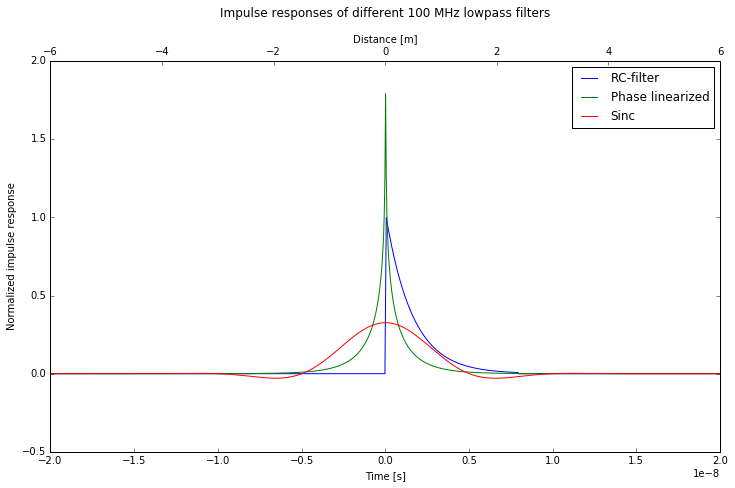

In [8]:
# The bandwidth of the feedback system is often minimized in order to minimize costs and possible 
# disturbances. For example, in the case of the feedback for the intrabunch oscillations, this means that
# time scale of the filter (1/f_cutoff) is on the same order than the length of the bunch (and signal) itself.
# Thus, behaviour of the filter can be understood better by looking at the impulse response of the filter
# instead of the frequency response (which assumes a signal of infinite length). The impulse response means
# the response of the filter, when a very short signal (Dirac delta function, Kronecker delta, etc) passes 
# through the filter. 
# 
# Impulse responses for the available lowpass filters are presented below. As it can be seen, the impulse 
# responses of the filters differ significantly, which affect also significantly the behaviour of 
# the feedback.

signal_1 = impulse(0.5*f_s,1000)
processors_1 = [Lowpass(f_s)]
process_signal(signal_1,processors_1)

signal_2 = impulse(0.5*f_s,1000)
processors_2 = [PhaseLinearizedLowpass(f_s)]
process_signal(signal_2,processors_2)

signal_3 = impulse(0.5*f_s,1000)
processors_3 = [Sinc(f_s)]
process_signal(signal_3,processors_3)

compare_signals([signal_1, signal_2, signal_3],
                ['RC-filter', 'Phase linearized',  'Sinc'],True,ylabel='Normalized impulse response',
               title = "Impulse responses of different 100 MHz lowpass filters")

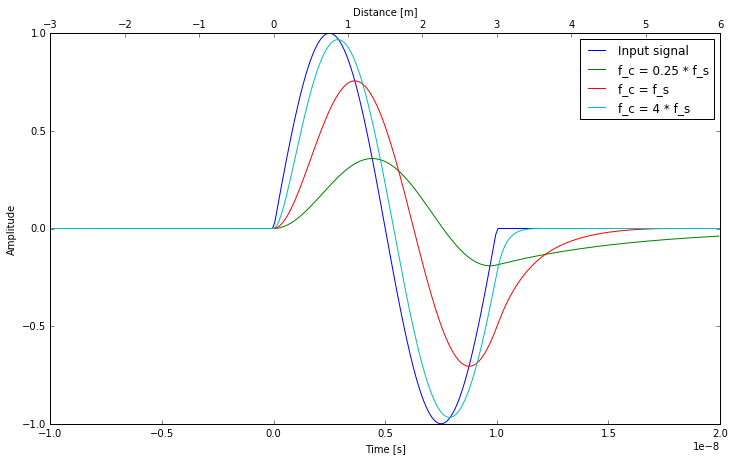

In [9]:
# The simplest filter (Lowpass(...)) is also called by RC-filter or one pole roll off. In the real life it 
# can be implemented by using a resistor and a capacitor. 

# The signal produced by an intra bunch oscillation can be emulated by using a period of sine signal. In the 
# figure below, a period of sine signal has been passed through RC-filters with different cut off 
# frequencies.
# 
# Two of the most significant effects to the feedback system are caused by the sharp tip and
# the unsymmetry of the impulse response. The sharp tip causes that the signals orders of magnitude above the 
# cutoff can pass through the filter, which is not realistic for the real life components (e.g. for power 
# amplifiers). The unsymmetric impulse response leads to situation, where the signal shifts in time (which corresponds 
# to phase shift in the frequency domain) and/or a bipolar input signal transforms 
# into an unipolar signal, when the frequency of the input signal is significantly higher than the cutoff 
# frequency of the filter (phase shift). This is a realistic feature of the filter, but it can lead to blow up
# of the bunch, i.e. it might be a critical and sensitive input parameter for the simulations.

signal_org = sine_impulse(f_s,1.0)

signal_1 = sine_impulse(f_s,1.0)
processors_1 = [Lowpass(0.25*f_s)]
process_signal(signal_1,processors_1)

signal_2 = sine_impulse(f_s,1.0)
processors_2 = [Lowpass(1.0 *f_s)]
process_signal(signal_2,processors_2)

signal_3 = sine_impulse(f_s,1.0)
processors_3 = [Lowpass(4.*f_s)]
process_signal(signal_3,processors_3)


compare_signals([signal_org, signal_1, signal_2, signal_3],
                ['Input signal', 'f_c = 0.25 * f_s',  'f_c = f_s',  'f_c = 4 * f_s'])

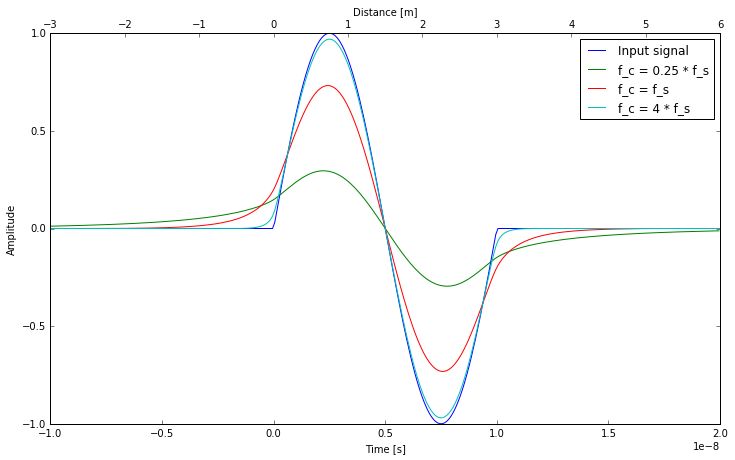

In [10]:
# Some of the problems with the RC filter can be avoided if the bandwidth of the feedback system is modelled 
# with a phaselinearized lowpass filter. The impulse response of the phase linearized lowpass filter is 
# symmetric, which means that a bipolar signal stays in bipolar form. However, the very sharp tip of the 
# impulse response often leads to the situation, where the signal can be damped with the system whose cutoff 
# frequency is orders of magnitude lower than the frequency of the signal itself, if the system has enough of 
# gain. This is basically never situation in the real live system, where bandwiths of the amplifiers end 
# shortly after the cutoff frequency or not more than one order magnitude above the cut off frequency. 
# Moreover, there are also limits for the phaselinearization in practice.



signal_org = sine_impulse(f_s,1.0)

signal_1 = sine_impulse(f_s,1.0)
processors_1 = [PhaseLinearizedLowpass(0.25*f_s)]
process_signal(signal_1,processors_1)

signal_2 = sine_impulse(f_s,1.0)
processors_2 = [PhaseLinearizedLowpass(1.0 *f_s)]
process_signal(signal_2,processors_2)

signal_3 = sine_impulse(f_s,1.0)
processors_3 = [PhaseLinearizedLowpass(4.*f_s)]
process_signal(signal_3,processors_3)


compare_signals([signal_org, signal_1, signal_2, signal_3],
                ['Input signal', 'f_c = 0.25 * f_s',  'f_c = f_s',  'f_c = 4 * f_s'])

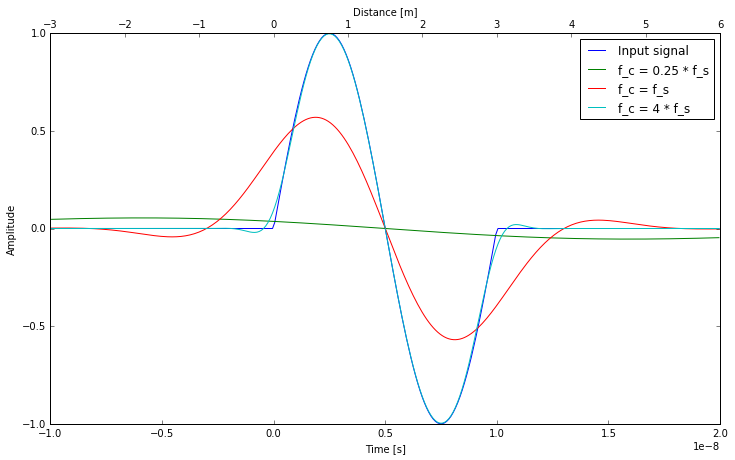

In [11]:
# The safest solution might be to use a Sinc filter. Its frequence response decays shortly after the cutoff
# frequency and the impulse response is smooth. This kind of behaviour can also be implemented to the real life system, 
# for example, by using FIR filters. However, there are some drawbacks also in this filter, such as the long impulse 
# response and the ripple

signal_org = sine_impulse(f_s,1.0)

signal_1 = sine_impulse(f_s,1.0)
processors_1 = [Sinc(0.25*f_s)]
process_signal(signal_1,processors_1)

signal_2 = sine_impulse(f_s,1.0)
processors_2 = [Sinc(1.0 *f_s)]
process_signal(signal_2,processors_2)

signal_3 = sine_impulse(f_s,1.0)
processors_3 = [Sinc(4.*f_s)]
process_signal(signal_3,processors_3)


compare_signals([signal_org, signal_1, signal_2, signal_3],
                ['Input signal', 'f_c = 0.25 * f_s',  'f_c = f_s',  'f_c = 4 * f_s'])

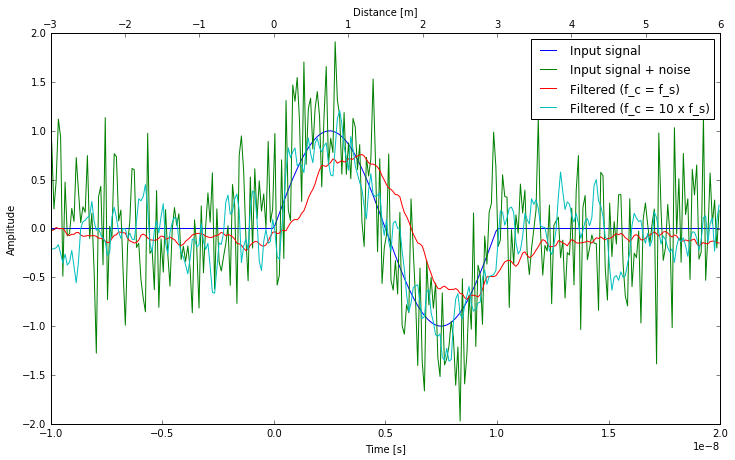

In [12]:
# Just for reminding, noise can be added to any part of the signal processor chain, but the final noise
# amplitude (and freguency spectrum) depends on the filters and processors after the noise generator.

signal_org = sine_impulse(f_s,1.0)

signal_1 = sine_impulse(f_s,1.0)
processors_1 = [NoiseGenerator(0.5)]
process_signal(signal_1,processors_1)

signal_2 = sine_impulse(f_s,1.0)
processors_2 = [NoiseGenerator(0.5),Lowpass(1.0 *f_s)]
process_signal(signal_2,processors_2)

signal_3 = sine_impulse(f_s,1.0)
processors_3 = [NoiseGenerator(0.5),Lowpass(10.*f_s)]
process_signal(signal_3,processors_3)


compare_signals([signal_org, signal_1, signal_2, signal_3],
                ['Input signal', 'Input signal + noise',  'Filtered (f_c = f_s)',  
                 'Filtered (f_c = 10 x f_s)'])

Jani Komppula, CERN, 2017